# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

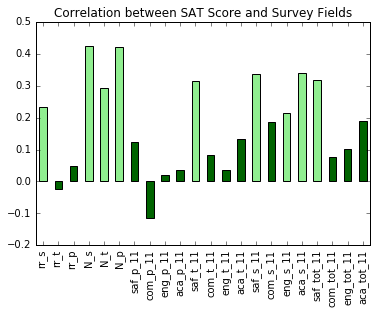

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

c = ['darkgreen' if x < 0.2 else 'lightgreen' for x in combined.corr()["sat_score"][survey_fields]]

graph1 = combined.corr()["sat_score"][survey_fields].plot.bar(color = c, title = "Correlation between SAT Score and Survey Fields")



`saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, are correlated highly with `sat_score`.

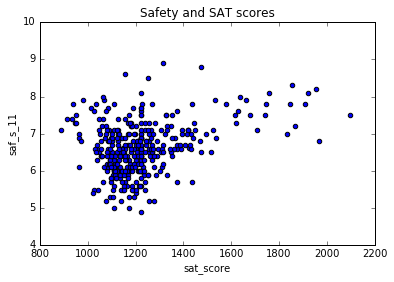

In [12]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.

# graph2 = combined["sat_score"]["saf_s_11"].plot.scatter()

prep = combined.loc[:, ["sat_score", "saf_s_11"]]

graph2 = prep.plot.scatter(x = "sat_score", y = "saf_s_11", title = "Safety and SAT scores")

Weak correlation but it can be observed that the highest SAT scores generally have higher safety scores as well. However, the bigg cluster shows that schools with high low SAT scores range in safety scores.

(-0.5, 0.8)

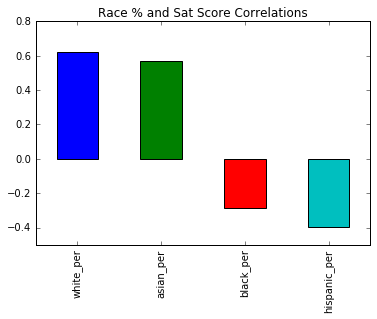

In [13]:
# Make a bar plot between different racial percentage makeup and SAT scores.

races = ["white_per", "asian_per", "black_per", "hispanic_per"]

racecorr = correlations[races]

graph_3 = racecorr.plot.bar(title = 'Race % and Sat Score Correlations')
graph_3.set_ylim(-0.5, 0.8)



Higher % of White and Asian students correlates with higher SAT scores. Higher % of Hispanic and Black students correlates with lower SAT scores.

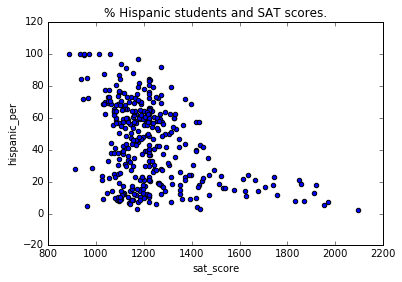

In [14]:
# Make a graph comparing hispanic % and SAT scores

preppp = combined.loc[:, ["sat_score", "hispanic_per"]]

graph_4 = preppp.plot.scatter( x = "sat_score", y = "hispanic_per", title = "% Hispanic students and SAT scores.")

Schools with low SAT scores can have a small or large % of Hisplanic students. However, schools with high SAT scores have less than 30% Hispanic students.

In [15]:
#Find schools where the hispanic % is higher than 95%

high_his = combined[combined["hispanic_per"] > 95]
high_his_names = high_his["SCHOOL NAME"].unique()


In [16]:
#Find schools where the hispanic % is lower than 1-%

low_his = combined[combined["hispanic_per"] < 10]
low_his_names = high_his["SCHOOL NAME"].unique()


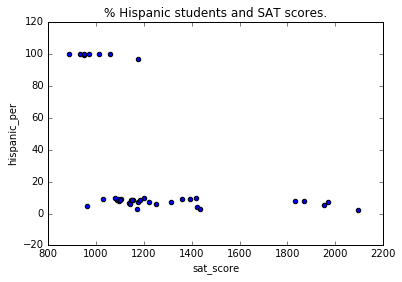

In [17]:
#SAT scores in high and low % Hispanic schools

compare_his = pd.concat([high_his, low_his], axis = 0)

prepppp = compare_his.loc[:, ["sat_score", "hispanic_per"]]

graph_5 = prepppp.plot.scatter(x = "sat_score", y = "hispanic_per", title = "% Hispanic students and SAT scores.")


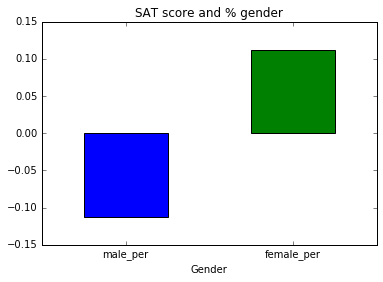

In [21]:
# SAT scores between % male / female schools

gender = ["male_per", "female_per"]

gender_corr = correlations[gender].plot.bar(rot = 0, title = "SAT score and % gender")
gender_corr.set_xlabel("Gender")

Higher percentage of female students may result in slightly higher average SAT scores.

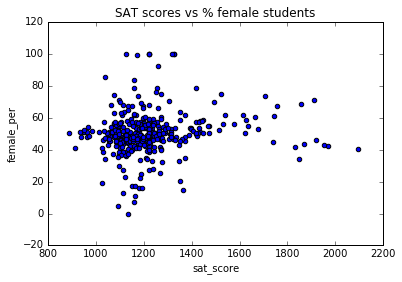

In [23]:
# Scatter plot for %female and SAT scores

preppppp = combined.loc[:, ["female_per", "sat_score"]]
graph_6 = preppppp.plot.scatter(x = "sat_score", y = "female_per", title = "SAT scores vs % female students")

In [29]:
# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

high_f = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
                                                     
high_f["SCHOOL NAME"].unique()


array(['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'TOWNSEND HARRIS HIGH SCHOOL'], dtype=object)

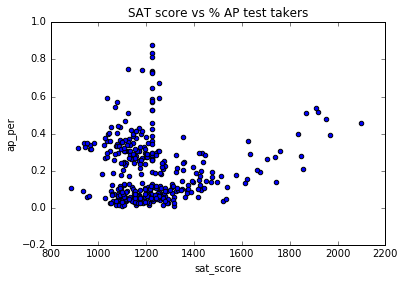

In [34]:
# Scatter plot between % AP test takers and SAT score

combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

graph_7 = combined.plot.scatter(x = "sat_score", y = "ap_per", title ="SAT score vs % AP test takers")
